<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:18:56] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


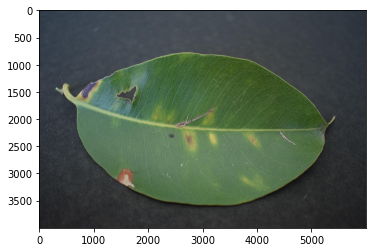

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

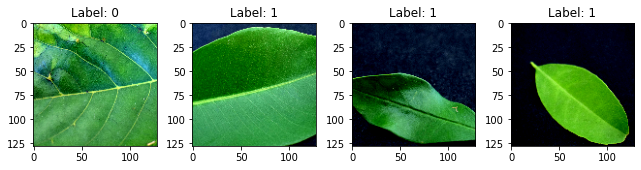

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:19:01] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:19:03] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2587484403709648 samples/sec                   batch loss = 0.5670380592346191 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.267912787888713 samples/sec                   batch loss = 0.7493054866790771 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2628401079237548 samples/sec                   batch loss = 0.8881949782371521 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2715815156856431 samples/sec                   batch loss = 0.15417757630348206 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2646952690512767 samples/sec                   batch loss = 0.6257460713386536 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.263108981856321 samples/sec                   batch loss = 0.43953269720077515 | accuracy = 0.6166666666666667


Epoch[1] Batch[35] Speed: 1.2651333892809131 samples/sec                   batch loss = 0.49140024185180664 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2667541309983739 samples/sec                   batch loss = 0.6446831822395325 | accuracy = 0.61875


Epoch[1] Batch[45] Speed: 1.2718359990223886 samples/sec                   batch loss = 1.1627788543701172 | accuracy = 0.6222222222222222


Epoch[1] Batch[50] Speed: 1.2698419041827798 samples/sec                   batch loss = 0.27469170093536377 | accuracy = 0.615


Epoch[1] Batch[55] Speed: 1.2632360427466285 samples/sec                   batch loss = 0.391256183385849 | accuracy = 0.6227272727272727


Epoch[1] Batch[60] Speed: 1.2691748502817348 samples/sec                   batch loss = 0.7117401957511902 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2695352835763432 samples/sec                   batch loss = 0.6165238618850708 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.2747903332367077 samples/sec                   batch loss = 0.5888941287994385 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.2726251589528335 samples/sec                   batch loss = 0.44833236932754517 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.272931245905724 samples/sec                   batch loss = 2.64341402053833 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.261104977425632 samples/sec                   batch loss = 0.6938502788543701 | accuracy = 0.6264705882352941


Epoch[1] Batch[90] Speed: 1.2669576017572401 samples/sec                   batch loss = 0.3912399709224701 | accuracy = 0.6305555555555555


Epoch[1] Batch[95] Speed: 1.267792257037887 samples/sec                   batch loss = 0.594696581363678 | accuracy = 0.6263157894736842


Epoch[1] Batch[100] Speed: 1.2674631655106385 samples/sec                   batch loss = 0.435275673866272 | accuracy = 0.6325


Epoch[1] Batch[105] Speed: 1.2617498139587877 samples/sec                   batch loss = 0.592264711856842 | accuracy = 0.6285714285714286


Epoch[1] Batch[110] Speed: 1.2652812780526337 samples/sec                   batch loss = 0.41498807072639465 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.27529383183654 samples/sec                   batch loss = 1.5725784301757812 | accuracy = 0.6369565217391304


Epoch[1] Batch[120] Speed: 1.273275359080734 samples/sec                   batch loss = 0.5269373655319214 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.2686659057441083 samples/sec                   batch loss = 1.1020166873931885 | accuracy = 0.638


Epoch[1] Batch[130] Speed: 1.268635399318967 samples/sec                   batch loss = 0.2757292091846466 | accuracy = 0.6423076923076924


Epoch[1] Batch[135] Speed: 1.2706165618347658 samples/sec                   batch loss = 0.7447940111160278 | accuracy = 0.6425925925925926


Epoch[1] Batch[140] Speed: 1.2664597068014056 samples/sec                   batch loss = 0.4703511595726013 | accuracy = 0.65


Epoch[1] Batch[145] Speed: 1.2734632410539164 samples/sec                   batch loss = 0.7934205532073975 | accuracy = 0.646551724137931


Epoch[1] Batch[150] Speed: 1.2642665027720514 samples/sec                   batch loss = 0.30306780338287354 | accuracy = 0.6483333333333333


Epoch[1] Batch[155] Speed: 1.2628375414329127 samples/sec                   batch loss = 0.5176278352737427 | accuracy = 0.6451612903225806


Epoch[1] Batch[160] Speed: 1.2641774313514227 samples/sec                   batch loss = 0.4854767918586731 | accuracy = 0.6453125


Epoch[1] Batch[165] Speed: 1.266807216502396 samples/sec                   batch loss = 0.35317757725715637 | accuracy = 0.6439393939393939


Epoch[1] Batch[170] Speed: 1.265584414947629 samples/sec                   batch loss = 0.9517925977706909 | accuracy = 0.6441176470588236


Epoch[1] Batch[175] Speed: 1.2627060940194774 samples/sec                   batch loss = 0.5945952534675598 | accuracy = 0.6414285714285715


Epoch[1] Batch[180] Speed: 1.2640979921391402 samples/sec                   batch loss = 0.6422269344329834 | accuracy = 0.6444444444444445


Epoch[1] Batch[185] Speed: 1.2605368463918472 samples/sec                   batch loss = 1.2953003644943237 | accuracy = 0.6418918918918919


Epoch[1] Batch[190] Speed: 1.2660095856903595 samples/sec                   batch loss = 0.29566049575805664 | accuracy = 0.6473684210526316


Epoch[1] Batch[195] Speed: 1.2596649906387907 samples/sec                   batch loss = 0.5174710154533386 | accuracy = 0.6474358974358975


Epoch[1] Batch[200] Speed: 1.2697329220774551 samples/sec                   batch loss = 0.4208142161369324 | accuracy = 0.64625


Epoch[1] Batch[205] Speed: 1.2634801550618195 samples/sec                   batch loss = 0.3582809269428253 | accuracy = 0.6451219512195122


Epoch[1] Batch[210] Speed: 1.2713069999791617 samples/sec                   batch loss = 0.5690648555755615 | accuracy = 0.6416666666666667


Epoch[1] Batch[215] Speed: 1.2722344120683649 samples/sec                   batch loss = 0.7288931608200073 | accuracy = 0.6453488372093024


Epoch[1] Batch[220] Speed: 1.2633167054371466 samples/sec                   batch loss = 0.4093017280101776 | accuracy = 0.6465909090909091


Epoch[1] Batch[225] Speed: 1.2634693078510988 samples/sec                   batch loss = 0.5308877825737 | accuracy = 0.6466666666666666


Epoch[1] Batch[230] Speed: 1.2653854888392657 samples/sec                   batch loss = 0.7467964887619019 | accuracy = 0.65


Epoch[1] Batch[235] Speed: 1.2691969332989883 samples/sec                   batch loss = 0.36706826090812683 | accuracy = 0.648936170212766


Epoch[1] Batch[240] Speed: 1.2682332929593283 samples/sec                   batch loss = 0.3961974084377289 | accuracy = 0.6510416666666666


Epoch[1] Batch[245] Speed: 1.2598729074416477 samples/sec                   batch loss = 0.6390715837478638 | accuracy = 0.6459183673469387


Epoch[1] Batch[250] Speed: 1.2623323360657557 samples/sec                   batch loss = 0.5582318305969238 | accuracy = 0.646


Epoch[1] Batch[255] Speed: 1.2717804666980799 samples/sec                   batch loss = 0.38950908184051514 | accuracy = 0.6490196078431373


Epoch[1] Batch[260] Speed: 1.2688650969557158 samples/sec                   batch loss = 0.3541613519191742 | accuracy = 0.6509615384615385


Epoch[1] Batch[265] Speed: 1.2675369951033826 samples/sec                   batch loss = 0.46838751435279846 | accuracy = 0.6537735849056604


Epoch[1] Batch[270] Speed: 1.2688835224243176 samples/sec                   batch loss = 1.0742487907409668 | accuracy = 0.6555555555555556


Epoch[1] Batch[275] Speed: 1.2626011838361133 samples/sec                   batch loss = 0.5176939964294434 | accuracy = 0.6545454545454545


Epoch[1] Batch[280] Speed: 1.2631440732148842 samples/sec                   batch loss = 1.467057466506958 | accuracy = 0.6553571428571429


Epoch[1] Batch[285] Speed: 1.2651875793465708 samples/sec                   batch loss = 0.2841006815433502 | accuracy = 0.6570175438596492


Epoch[1] Batch[290] Speed: 1.259841403350788 samples/sec                   batch loss = 0.661806583404541 | accuracy = 0.6594827586206896


Epoch[1] Batch[295] Speed: 1.265033893906215 samples/sec                   batch loss = 0.2612549364566803 | accuracy = 0.6601694915254237


Epoch[1] Batch[300] Speed: 1.2626585781896358 samples/sec                   batch loss = 0.7918744683265686 | accuracy = 0.66


Epoch[1] Batch[305] Speed: 1.2633993763584928 samples/sec                   batch loss = 0.6671084761619568 | accuracy = 0.659016393442623


Epoch[1] Batch[310] Speed: 1.260206493333731 samples/sec                   batch loss = 0.26859790086746216 | accuracy = 0.6612903225806451


Epoch[1] Batch[315] Speed: 1.261123367803244 samples/sec                   batch loss = 0.6943876147270203 | accuracy = 0.6611111111111111


Epoch[1] Batch[320] Speed: 1.259846322804712 samples/sec                   batch loss = 0.6128749847412109 | accuracy = 0.6640625


Epoch[1] Batch[325] Speed: 1.256421958231641 samples/sec                   batch loss = 0.5142294764518738 | accuracy = 0.6630769230769231


Epoch[1] Batch[330] Speed: 1.2534323634505113 samples/sec                   batch loss = 0.43301236629486084 | accuracy = 0.6666666666666666


Epoch[1] Batch[335] Speed: 1.2609163648257489 samples/sec                   batch loss = 0.40341997146606445 | accuracy = 0.6701492537313433


Epoch[1] Batch[340] Speed: 1.2645971770532347 samples/sec                   batch loss = 0.28852251172065735 | accuracy = 0.6727941176470589


Epoch[1] Batch[345] Speed: 1.270070019874822 samples/sec                   batch loss = 1.1480991840362549 | accuracy = 0.672463768115942


Epoch[1] Batch[350] Speed: 1.2732317791585637 samples/sec                   batch loss = 0.5475029945373535 | accuracy = 0.6721428571428572


Epoch[1] Batch[355] Speed: 1.2645122525416355 samples/sec                   batch loss = 0.5890921950340271 | accuracy = 0.6725352112676056


Epoch[1] Batch[360] Speed: 1.2670963475513606 samples/sec                   batch loss = 0.9999986886978149 | accuracy = 0.6736111111111112


Epoch[1] Batch[365] Speed: 1.2669724317537552 samples/sec                   batch loss = 0.4085261821746826 | accuracy = 0.6732876712328767


Epoch[1] Batch[370] Speed: 1.2703693958269997 samples/sec                   batch loss = 0.3083927035331726 | accuracy = 0.675


Epoch[1] Batch[375] Speed: 1.2711363185041562 samples/sec                   batch loss = 0.7270002365112305 | accuracy = 0.6753333333333333


Epoch[1] Batch[380] Speed: 1.2719655933074105 samples/sec                   batch loss = 0.5425602197647095 | accuracy = 0.6756578947368421


Epoch[1] Batch[385] Speed: 1.2695822615829444 samples/sec                   batch loss = 0.47080981731414795 | accuracy = 0.675974025974026


Epoch[1] Batch[390] Speed: 1.2725351954568265 samples/sec                   batch loss = 0.7824638485908508 | accuracy = 0.6743589743589744


Epoch[1] Batch[395] Speed: 1.2671775040028834 samples/sec                   batch loss = 0.27942344546318054 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.2704299036433313 samples/sec                   batch loss = 0.3261125683784485 | accuracy = 0.6775


Epoch[1] Batch[405] Speed: 1.2711568325334375 samples/sec                   batch loss = 0.262060284614563 | accuracy = 0.6777777777777778


Epoch[1] Batch[410] Speed: 1.2736238158286393 samples/sec                   batch loss = 0.5458855032920837 | accuracy = 0.676219512195122


Epoch[1] Batch[415] Speed: 1.2699935876633637 samples/sec                   batch loss = 0.912405788898468 | accuracy = 0.6759036144578313


Epoch[1] Batch[420] Speed: 1.273708324776637 samples/sec                   batch loss = 0.41578060388565063 | accuracy = 0.6773809523809524


Epoch[1] Batch[425] Speed: 1.2671040990746794 samples/sec                   batch loss = 0.6800439953804016 | accuracy = 0.6776470588235294


Epoch[1] Batch[430] Speed: 1.2706000105421258 samples/sec                   batch loss = 0.9244723916053772 | accuracy = 0.6779069767441861


Epoch[1] Batch[435] Speed: 1.2755207105418753 samples/sec                   batch loss = 0.5215408802032471 | accuracy = 0.6758620689655173


Epoch[1] Batch[440] Speed: 1.2674809757536285 samples/sec                   batch loss = 0.3606134057044983 | accuracy = 0.6778409090909091


Epoch[1] Batch[445] Speed: 1.2725552720443452 samples/sec                   batch loss = 0.34061968326568604 | accuracy = 0.6780898876404494


Epoch[1] Batch[450] Speed: 1.2698233547609323 samples/sec                   batch loss = 0.30701616406440735 | accuracy = 0.6783333333333333


Epoch[1] Batch[455] Speed: 1.2739114241663436 samples/sec                   batch loss = 0.2637318968772888 | accuracy = 0.6785714285714286


Epoch[1] Batch[460] Speed: 1.2704555899439853 samples/sec                   batch loss = 0.9883027076721191 | accuracy = 0.6760869565217391


Epoch[1] Batch[465] Speed: 1.2683910171522785 samples/sec                   batch loss = 0.6000354290008545 | accuracy = 0.6774193548387096


Epoch[1] Batch[470] Speed: 1.2685803379762408 samples/sec                   batch loss = 0.8363308310508728 | accuracy = 0.6771276595744681


Epoch[1] Batch[475] Speed: 1.266255057935876 samples/sec                   batch loss = 0.4231939911842346 | accuracy = 0.6784210526315789


Epoch[1] Batch[480] Speed: 1.2707397477912878 samples/sec                   batch loss = 0.41531744599342346 | accuracy = 0.6786458333333333


Epoch[1] Batch[485] Speed: 1.270439908670654 samples/sec                   batch loss = 0.5067098140716553 | accuracy = 0.6798969072164949


Epoch[1] Batch[490] Speed: 1.2682216929109158 samples/sec                   batch loss = 0.8881187438964844 | accuracy = 0.6801020408163265


Epoch[1] Batch[495] Speed: 1.275453802019003 samples/sec                   batch loss = 0.6396875381469727 | accuracy = 0.6813131313131313


Epoch[1] Batch[500] Speed: 1.266711761437538 samples/sec                   batch loss = 1.1594243049621582 | accuracy = 0.6795


Epoch[1] Batch[505] Speed: 1.2744500477390368 samples/sec                   batch loss = 0.4662971794605255 | accuracy = 0.6797029702970298


Epoch[1] Batch[510] Speed: 1.2687635745442885 samples/sec                   batch loss = 0.27128979563713074 | accuracy = 0.6803921568627451


Epoch[1] Batch[515] Speed: 1.270248974527736 samples/sec                   batch loss = 0.47661319375038147 | accuracy = 0.6810679611650485


Epoch[1] Batch[520] Speed: 1.2643149019187014 samples/sec                   batch loss = 0.294070303440094 | accuracy = 0.6822115384615385


Epoch[1] Batch[525] Speed: 1.2706528414671765 samples/sec                   batch loss = 0.43373265862464905 | accuracy = 0.6838095238095238


Epoch[1] Batch[530] Speed: 1.2669090957419655 samples/sec                   batch loss = 0.5065078139305115 | accuracy = 0.6849056603773584


Epoch[1] Batch[535] Speed: 1.2659657374938351 samples/sec                   batch loss = 0.4038543999195099 | accuracy = 0.685981308411215


Epoch[1] Batch[540] Speed: 1.2734055368329156 samples/sec                   batch loss = 0.4212595820426941 | accuracy = 0.6861111111111111


Epoch[1] Batch[545] Speed: 1.2645246426126429 samples/sec                   batch loss = 0.11273040622472763 | accuracy = 0.6871559633027523


Epoch[1] Batch[550] Speed: 1.269605992081732 samples/sec                   batch loss = 0.38233718276023865 | accuracy = 0.6868181818181818


Epoch[1] Batch[555] Speed: 1.2697423395456338 samples/sec                   batch loss = 0.554489016532898 | accuracy = 0.686036036036036


Epoch[1] Batch[560] Speed: 1.273010350350671 samples/sec                   batch loss = 0.44692766666412354 | accuracy = 0.6866071428571429


Epoch[1] Batch[565] Speed: 1.2708400464971337 samples/sec                   batch loss = 0.1732509732246399 | accuracy = 0.6884955752212389


Epoch[1] Batch[570] Speed: 1.2727584866226287 samples/sec                   batch loss = 0.23363466560840607 | accuracy = 0.6899122807017544


Epoch[1] Batch[575] Speed: 1.2708666157932667 samples/sec                   batch loss = 1.3604023456573486 | accuracy = 0.6891304347826087


Epoch[1] Batch[580] Speed: 1.2711065598921607 samples/sec                   batch loss = 0.4655117392539978 | accuracy = 0.6892241379310344


Epoch[1] Batch[585] Speed: 1.2693694953335741 samples/sec                   batch loss = 0.472525954246521 | accuracy = 0.6893162393162393


Epoch[1] Batch[590] Speed: 1.2671712829164217 samples/sec                   batch loss = 0.313188761472702 | accuracy = 0.6894067796610169


Epoch[1] Batch[595] Speed: 1.266701049943257 samples/sec                   batch loss = 1.1801527738571167 | accuracy = 0.6907563025210084


Epoch[1] Batch[600] Speed: 1.2721560792649873 samples/sec                   batch loss = 0.46407604217529297 | accuracy = 0.69125


Epoch[1] Batch[605] Speed: 1.2667059274762245 samples/sec                   batch loss = 0.47788214683532715 | accuracy = 0.6925619834710743


Epoch[1] Batch[610] Speed: 1.2647964274653827 samples/sec                   batch loss = 0.44462358951568604 | accuracy = 0.6930327868852459


Epoch[1] Batch[615] Speed: 1.2699932031220371 samples/sec                   batch loss = 0.8996971249580383 | accuracy = 0.6934959349593496


Epoch[1] Batch[620] Speed: 1.2666213888883018 samples/sec                   batch loss = 0.15697811543941498 | accuracy = 0.6939516129032258


Epoch[1] Batch[625] Speed: 1.2665880164665646 samples/sec                   batch loss = 0.18943120539188385 | accuracy = 0.6952


Epoch[1] Batch[630] Speed: 1.2728668298907497 samples/sec                   batch loss = 0.9920434355735779 | accuracy = 0.6944444444444444


Epoch[1] Batch[635] Speed: 1.2673607184574431 samples/sec                   batch loss = 0.13438056409358978 | accuracy = 0.6964566929133859


Epoch[1] Batch[640] Speed: 1.2275834456243948 samples/sec                   batch loss = 0.451724112033844 | accuracy = 0.697265625


Epoch[1] Batch[645] Speed: 1.2685995225705275 samples/sec                   batch loss = 0.7475038766860962 | accuracy = 0.6957364341085271


Epoch[1] Batch[650] Speed: 1.2697425317403166 samples/sec                   batch loss = 1.007409930229187 | accuracy = 0.6961538461538461


Epoch[1] Batch[655] Speed: 1.2736232357144348 samples/sec                   batch loss = 0.2899128794670105 | accuracy = 0.6958015267175572


Epoch[1] Batch[660] Speed: 1.270626088646405 samples/sec                   batch loss = 0.30427730083465576 | accuracy = 0.6962121212121212


Epoch[1] Batch[665] Speed: 1.2679934739649004 samples/sec                   batch loss = 1.2821810245513916 | accuracy = 0.6962406015037594


Epoch[1] Batch[670] Speed: 1.2720692684623005 samples/sec                   batch loss = 0.2967650890350342 | accuracy = 0.6962686567164179


Epoch[1] Batch[675] Speed: 1.2688895683978034 samples/sec                   batch loss = 0.22765666246414185 | accuracy = 0.6981481481481482


Epoch[1] Batch[680] Speed: 1.2743286580193904 samples/sec                   batch loss = 0.10779750347137451 | accuracy = 0.6988970588235294


Epoch[1] Batch[685] Speed: 1.2709571137607498 samples/sec                   batch loss = 0.5250219106674194 | accuracy = 0.6967153284671533


Epoch[1] Batch[690] Speed: 1.2705897143160074 samples/sec                   batch loss = 0.5797569155693054 | accuracy = 0.6971014492753623


Epoch[1] Batch[695] Speed: 1.2732840560963314 samples/sec                   batch loss = 0.38820815086364746 | accuracy = 0.697841726618705


Epoch[1] Batch[700] Speed: 1.272709825061357 samples/sec                   batch loss = 0.9557199478149414 | accuracy = 0.6982142857142857


Epoch[1] Batch[705] Speed: 1.2718784228152507 samples/sec                   batch loss = 0.88204425573349 | accuracy = 0.6982269503546099


Epoch[1] Batch[710] Speed: 1.2725173394088547 samples/sec                   batch loss = 0.6929839253425598 | accuracy = 0.698943661971831


Epoch[1] Batch[715] Speed: 1.2706156957680643 samples/sec                   batch loss = 0.5730060338973999 | accuracy = 0.6982517482517483


Epoch[1] Batch[720] Speed: 1.2694264501423425 samples/sec                   batch loss = 0.45189908146858215 | accuracy = 0.6982638888888889


Epoch[1] Batch[725] Speed: 1.2726995911589594 samples/sec                   batch loss = 0.7307987809181213 | accuracy = 0.6979310344827586


Epoch[1] Batch[730] Speed: 1.2687936073651247 samples/sec                   batch loss = 0.16453322768211365 | accuracy = 0.6976027397260274


Epoch[1] Batch[735] Speed: 1.2710186404828734 samples/sec                   batch loss = 0.23019225895404816 | accuracy = 0.6993197278911565


Epoch[1] Batch[740] Speed: 1.2707285830797515 samples/sec                   batch loss = 0.47158733010292053 | accuracy = 0.6996621621621621


Epoch[1] Batch[745] Speed: 1.2730866630997124 samples/sec                   batch loss = 1.424951195716858 | accuracy = 0.6993288590604027


Epoch[1] Batch[750] Speed: 1.26709184979736 samples/sec                   batch loss = 0.47358354926109314 | accuracy = 0.6996666666666667


Epoch[1] Batch[755] Speed: 1.269264051185703 samples/sec                   batch loss = 0.4633502662181854 | accuracy = 0.6990066225165563


Epoch[1] Batch[760] Speed: 1.2718609708668973 samples/sec                   batch loss = 0.44210296869277954 | accuracy = 0.6990131578947368


Epoch[1] Batch[765] Speed: 1.278073217256699 samples/sec                   batch loss = 0.3486265540122986 | accuracy = 0.7


Epoch[1] Batch[770] Speed: 1.268976617608573 samples/sec                   batch loss = 0.5353373885154724 | accuracy = 0.7


Epoch[1] Batch[775] Speed: 1.2765350884367892 samples/sec                   batch loss = 0.3420621454715729 | accuracy = 0.6990322580645161


Epoch[1] Batch[780] Speed: 1.265943002587691 samples/sec                   batch loss = 0.30004966259002686 | accuracy = 0.7


Epoch[1] Batch[785] Speed: 1.2663344817526623 samples/sec                   batch loss = 1.0292043685913086 | accuracy = 0.6993630573248407


[Epoch 1] training: accuracy=0.6998730964467005
[Epoch 1] time cost: 649.3068780899048
[Epoch 1] validation: validation accuracy=0.7233333333333334


Epoch[2] Batch[5] Speed: 1.273072848847974 samples/sec                   batch loss = 0.4013618528842926 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.270391231846406 samples/sec                   batch loss = 0.1348874866962433 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2718622243057875 samples/sec                   batch loss = 0.7600013613700867 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.276631349802835 samples/sec                   batch loss = 0.41462191939353943 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2730159527476401 samples/sec                   batch loss = 0.7908177971839905 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2699753222075227 samples/sec                   batch loss = 0.4107576310634613 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2773247437389281 samples/sec                   batch loss = 0.2627505660057068 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2772448105032221 samples/sec                   batch loss = 0.3852080702781677 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.27453292354124 samples/sec                   batch loss = 0.571973979473114 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2754010559001914 samples/sec                   batch loss = 0.8682059049606323 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.2738862750145121 samples/sec                   batch loss = 0.41965270042419434 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2715395935445697 samples/sec                   batch loss = 0.3942691683769226 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2713581555548854 samples/sec                   batch loss = 0.6061933636665344 | accuracy = 0.7461538461538462


Epoch[2] Batch[70] Speed: 1.2773543079565122 samples/sec                   batch loss = 0.3138386011123657 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.2745800784870487 samples/sec                   batch loss = 0.7112661600112915 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.2792907252730896 samples/sec                   batch loss = 0.6002632975578308 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.2737425569925456 samples/sec                   batch loss = 0.32124507427215576 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.2710550393762887 samples/sec                   batch loss = 0.6961578726768494 | accuracy = 0.7388888888888889


Epoch[2] Batch[95] Speed: 1.271998767518284 samples/sec                   batch loss = 0.35744205117225647 | accuracy = 0.7342105263157894


Epoch[2] Batch[100] Speed: 1.2669020162791453 samples/sec                   batch loss = 0.7779249548912048 | accuracy = 0.735


Epoch[2] Batch[105] Speed: 1.2762078501023912 samples/sec                   batch loss = 0.7503089308738708 | accuracy = 0.7285714285714285


Epoch[2] Batch[110] Speed: 1.2713732814383483 samples/sec                   batch loss = 0.5225111246109009 | accuracy = 0.7272727272727273


Epoch[2] Batch[115] Speed: 1.2694181899375332 samples/sec                   batch loss = 0.6160918474197388 | accuracy = 0.7326086956521739


Epoch[2] Batch[120] Speed: 1.2739733340015589 samples/sec                   batch loss = 0.33251088857650757 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2739292226276744 samples/sec                   batch loss = 0.5661234855651855 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.273022327949002 samples/sec                   batch loss = 0.8480135798454285 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.2693782351156027 samples/sec                   batch loss = 0.8315948843955994 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.2743961261651873 samples/sec                   batch loss = 0.6209925413131714 | accuracy = 0.7339285714285714


Epoch[2] Batch[145] Speed: 1.2713505445776654 samples/sec                   batch loss = 0.16093608736991882 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.2708981923434994 samples/sec                   batch loss = 0.302433580160141 | accuracy = 0.7366666666666667


Epoch[2] Batch[155] Speed: 1.2744943888252507 samples/sec                   batch loss = 0.5769685506820679 | accuracy = 0.7322580645161291


Epoch[2] Batch[160] Speed: 1.2692360125213737 samples/sec                   batch loss = 0.4310261607170105 | accuracy = 0.73125


Epoch[2] Batch[165] Speed: 1.2688504145435295 samples/sec                   batch loss = 0.2596323788166046 | accuracy = 0.7333333333333333


Epoch[2] Batch[170] Speed: 1.2708744135149546 samples/sec                   batch loss = 0.31649428606033325 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.27347000738553 samples/sec                   batch loss = 0.452047199010849 | accuracy = 0.74


Epoch[2] Batch[180] Speed: 1.2694837942949708 samples/sec                   batch loss = 0.20188498497009277 | accuracy = 0.7402777777777778


Epoch[2] Batch[185] Speed: 1.2737421701775677 samples/sec                   batch loss = 1.03463613986969 | accuracy = 0.7391891891891892


Epoch[2] Batch[190] Speed: 1.2800357431855778 samples/sec                   batch loss = 0.10610105097293854 | accuracy = 0.7394736842105263


Epoch[2] Batch[195] Speed: 1.2737053271278356 samples/sec                   batch loss = 0.177291139960289 | accuracy = 0.7423076923076923


Epoch[2] Batch[200] Speed: 1.2870728518196768 samples/sec                   batch loss = 0.22915568947792053 | accuracy = 0.74375


Epoch[2] Batch[205] Speed: 1.2703613157281608 samples/sec                   batch loss = 0.6100165843963623 | accuracy = 0.7451219512195122


Epoch[2] Batch[210] Speed: 1.2657699383924952 samples/sec                   batch loss = 0.7360398769378662 | accuracy = 0.7476190476190476


Epoch[2] Batch[215] Speed: 1.273347161334583 samples/sec                   batch loss = 0.34074297547340393 | accuracy = 0.7488372093023256


Epoch[2] Batch[220] Speed: 1.2674464090185844 samples/sec                   batch loss = 0.4296523630619049 | accuracy = 0.7465909090909091


Epoch[2] Batch[225] Speed: 1.2739274814519017 samples/sec                   batch loss = 0.17623193562030792 | accuracy = 0.7488888888888889


Epoch[2] Batch[230] Speed: 1.271449494389916 samples/sec                   batch loss = 0.5842903852462769 | accuracy = 0.7456521739130435


Epoch[2] Batch[235] Speed: 1.2711837040241762 samples/sec                   batch loss = 0.40239933133125305 | accuracy = 0.75


Epoch[2] Batch[240] Speed: 1.2720050360955308 samples/sec                   batch loss = 0.6277725100517273 | accuracy = 0.7447916666666666


Epoch[2] Batch[245] Speed: 1.2728646087651347 samples/sec                   batch loss = 0.9884799122810364 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.2709857099470225 samples/sec                   batch loss = 0.2762289047241211 | accuracy = 0.745


Epoch[2] Batch[255] Speed: 1.2730966134108306 samples/sec                   batch loss = 0.5494674444198608 | accuracy = 0.7450980392156863


Epoch[2] Batch[260] Speed: 1.2720763093414404 samples/sec                   batch loss = 0.8739157915115356 | accuracy = 0.7442307692307693


Epoch[2] Batch[265] Speed: 1.2670845769010064 samples/sec                   batch loss = 0.6671315431594849 | accuracy = 0.7405660377358491


Epoch[2] Batch[270] Speed: 1.2713466909530642 samples/sec                   batch loss = 0.25410306453704834 | accuracy = 0.7444444444444445


Epoch[2] Batch[275] Speed: 1.2687574338230934 samples/sec                   batch loss = 0.41843298077583313 | accuracy = 0.7454545454545455


Epoch[2] Batch[280] Speed: 1.271752220345272 samples/sec                   batch loss = 0.452920526266098 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.2745322457748474 samples/sec                   batch loss = 0.7607893943786621 | accuracy = 0.7473684210526316


Epoch[2] Batch[290] Speed: 1.2730481191880034 samples/sec                   batch loss = 0.5677071809768677 | accuracy = 0.7482758620689656


Epoch[2] Batch[295] Speed: 1.2749771123390312 samples/sec                   batch loss = 0.6088905930519104 | accuracy = 0.75


Epoch[2] Batch[300] Speed: 1.2654376961169356 samples/sec                   batch loss = 0.6210402250289917 | accuracy = 0.7475


Epoch[2] Batch[305] Speed: 1.2686118969416766 samples/sec                   batch loss = 0.7427828907966614 | accuracy = 0.7467213114754099


Epoch[2] Batch[310] Speed: 1.2697774160388753 samples/sec                   batch loss = 0.18411630392074585 | accuracy = 0.7467741935483871


Epoch[2] Batch[315] Speed: 1.2699778216599245 samples/sec                   batch loss = 0.650478184223175 | accuracy = 0.7468253968253968


Epoch[2] Batch[320] Speed: 1.2752606794010692 samples/sec                   batch loss = 0.48532694578170776 | accuracy = 0.74921875


Epoch[2] Batch[325] Speed: 1.2731782504766294 samples/sec                   batch loss = 0.6858747601509094 | accuracy = 0.7507692307692307


Epoch[2] Batch[330] Speed: 1.2708232005986435 samples/sec                   batch loss = 0.34535840153694153 | accuracy = 0.7522727272727273


Epoch[2] Batch[335] Speed: 1.2803305540920293 samples/sec                   batch loss = 0.36330151557922363 | accuracy = 0.7522388059701492


Epoch[2] Batch[340] Speed: 1.2738890800630156 samples/sec                   batch loss = 0.3610493540763855 | accuracy = 0.7514705882352941


Epoch[2] Batch[345] Speed: 1.2747566258264025 samples/sec                   batch loss = 0.1912260502576828 | accuracy = 0.7507246376811594


Epoch[2] Batch[350] Speed: 1.2691263663527366 samples/sec                   batch loss = 0.683271586894989 | accuracy = 0.7492857142857143


Epoch[2] Batch[355] Speed: 1.2768580244550516 samples/sec                   batch loss = 0.3595104217529297 | accuracy = 0.7492957746478873


Epoch[2] Batch[360] Speed: 1.2684920963155455 samples/sec                   batch loss = 0.5121040344238281 | accuracy = 0.7493055555555556


Epoch[2] Batch[365] Speed: 1.267119793807363 samples/sec                   batch loss = 0.45762360095977783 | accuracy = 0.7493150684931507


Epoch[2] Batch[370] Speed: 1.273318555428565 samples/sec                   batch loss = 0.24322590231895447 | accuracy = 0.7506756756756757


Epoch[2] Batch[375] Speed: 1.2712260843111263 samples/sec                   batch loss = 0.47008371353149414 | accuracy = 0.7513333333333333


Epoch[2] Batch[380] Speed: 1.2725620287306931 samples/sec                   batch loss = 0.12764623761177063 | accuracy = 0.7526315789473684


Epoch[2] Batch[385] Speed: 1.2734681708026967 samples/sec                   batch loss = 0.1451004445552826 | accuracy = 0.7545454545454545


Epoch[2] Batch[390] Speed: 1.277881052642964 samples/sec                   batch loss = 0.21553392708301544 | accuracy = 0.7564102564102564


Epoch[2] Batch[395] Speed: 1.284044674107351 samples/sec                   batch loss = 0.961722195148468 | accuracy = 0.7550632911392405


Epoch[2] Batch[400] Speed: 1.2740109665136183 samples/sec                   batch loss = 0.5192584991455078 | accuracy = 0.755


Epoch[2] Batch[405] Speed: 1.2751174264134015 samples/sec                   batch loss = 0.3898303806781769 | accuracy = 0.7567901234567901


Epoch[2] Batch[410] Speed: 1.272249076423671 samples/sec                   batch loss = 0.20305228233337402 | accuracy = 0.7560975609756098


Epoch[2] Batch[415] Speed: 1.2731781538585294 samples/sec                   batch loss = 0.40517109632492065 | accuracy = 0.7566265060240964


Epoch[2] Batch[420] Speed: 1.2714637552236807 samples/sec                   batch loss = 0.40751317143440247 | accuracy = 0.7577380952380952


Epoch[2] Batch[425] Speed: 1.2744129701165134 samples/sec                   batch loss = 0.9166116714477539 | accuracy = 0.7558823529411764


Epoch[2] Batch[430] Speed: 1.273889273515092 samples/sec                   batch loss = 0.15160147845745087 | accuracy = 0.7575581395348837


Epoch[2] Batch[435] Speed: 1.2682371277327467 samples/sec                   batch loss = 0.7633036375045776 | accuracy = 0.7580459770114942


Epoch[2] Batch[440] Speed: 1.2676067149877737 samples/sec                   batch loss = 0.19007760286331177 | accuracy = 0.7568181818181818


Epoch[2] Batch[445] Speed: 1.2712201123723805 samples/sec                   batch loss = 0.7185593247413635 | accuracy = 0.7556179775280899


Epoch[2] Batch[450] Speed: 1.2769943789222906 samples/sec                   batch loss = 0.2986028790473938 | accuracy = 0.755


Epoch[2] Batch[455] Speed: 1.2683823868506645 samples/sec                   batch loss = 0.9079946279525757 | accuracy = 0.7538461538461538


Epoch[2] Batch[460] Speed: 1.276832661654584 samples/sec                   batch loss = 0.29469984769821167 | accuracy = 0.7548913043478261


Epoch[2] Batch[465] Speed: 1.2786264754658083 samples/sec                   batch loss = 0.5393235087394714 | accuracy = 0.7548387096774194


Epoch[2] Batch[470] Speed: 1.2656441813593389 samples/sec                   batch loss = 0.7772711515426636 | accuracy = 0.7531914893617021


Epoch[2] Batch[475] Speed: 1.2675980953558168 samples/sec                   batch loss = 0.2919885218143463 | accuracy = 0.7536842105263157


Epoch[2] Batch[480] Speed: 1.2669681262351307 samples/sec                   batch loss = 0.5601792335510254 | accuracy = 0.7541666666666667


Epoch[2] Batch[485] Speed: 1.2681754865597956 samples/sec                   batch loss = 0.4968120753765106 | accuracy = 0.7541237113402062


Epoch[2] Batch[490] Speed: 1.2711903498369 samples/sec                   batch loss = 0.3866056799888611 | accuracy = 0.7545918367346939


Epoch[2] Batch[495] Speed: 1.2732776782732764 samples/sec                   batch loss = 0.4729657471179962 | accuracy = 0.7550505050505051


Epoch[2] Batch[500] Speed: 1.2694562261913815 samples/sec                   batch loss = 0.7579721808433533 | accuracy = 0.7555


Epoch[2] Batch[505] Speed: 1.2729751916058318 samples/sec                   batch loss = 0.2875552475452423 | accuracy = 0.755940594059406


Epoch[2] Batch[510] Speed: 1.267310458436121 samples/sec                   batch loss = 1.4935226440429688 | accuracy = 0.7553921568627451


Epoch[2] Batch[515] Speed: 1.2735644535482893 samples/sec                   batch loss = 1.0828793048858643 | accuracy = 0.7553398058252427


Epoch[2] Batch[520] Speed: 1.2778733633670711 samples/sec                   batch loss = 0.3968743085861206 | accuracy = 0.7552884615384615


Epoch[2] Batch[525] Speed: 1.2726081691639108 samples/sec                   batch loss = 0.3834311068058014 | accuracy = 0.7552380952380953


Epoch[2] Batch[530] Speed: 1.2743560509675091 samples/sec                   batch loss = 1.0503716468811035 | accuracy = 0.754245283018868


Epoch[2] Batch[535] Speed: 1.2806289221475116 samples/sec                   batch loss = 0.7405528426170349 | accuracy = 0.7546728971962616


Epoch[2] Batch[540] Speed: 1.2777812939096003 samples/sec                   batch loss = 0.44640353322029114 | accuracy = 0.7560185185185185


Epoch[2] Batch[545] Speed: 1.276901755787711 samples/sec                   batch loss = 0.26778221130371094 | accuracy = 0.7555045871559632


Epoch[2] Batch[550] Speed: 1.2754366396596164 samples/sec                   batch loss = 0.2151370644569397 | accuracy = 0.7559090909090909


Epoch[2] Batch[555] Speed: 1.276498472132336 samples/sec                   batch loss = 0.41693344712257385 | accuracy = 0.7572072072072072


Epoch[2] Batch[560] Speed: 1.2712044122204382 samples/sec                   batch loss = 0.720037579536438 | accuracy = 0.7575892857142857


Epoch[2] Batch[565] Speed: 1.2718817011352253 samples/sec                   batch loss = 0.8353585004806519 | accuracy = 0.7575221238938054


Epoch[2] Batch[570] Speed: 1.2751251794724894 samples/sec                   batch loss = 2.041670560836792 | accuracy = 0.7570175438596491


Epoch[2] Batch[575] Speed: 1.2747030657061196 samples/sec                   batch loss = 0.1957816630601883 | accuracy = 0.7556521739130435


Epoch[2] Batch[580] Speed: 1.274978371927461 samples/sec                   batch loss = 0.28412342071533203 | accuracy = 0.756896551724138


Epoch[2] Batch[585] Speed: 1.273651371862088 samples/sec                   batch loss = 0.6465258002281189 | accuracy = 0.7572649572649572


Epoch[2] Batch[590] Speed: 1.273785591625816 samples/sec                   batch loss = 0.5907585620880127 | accuracy = 0.7576271186440678


Epoch[2] Batch[595] Speed: 1.2767912670641257 samples/sec                   batch loss = 0.293080598115921 | accuracy = 0.7571428571428571


Epoch[2] Batch[600] Speed: 1.2753585906879876 samples/sec                   batch loss = 0.9562926292419434 | accuracy = 0.7558333333333334


Epoch[2] Batch[605] Speed: 1.2644939538039432 samples/sec                   batch loss = 0.9415601491928101 | accuracy = 0.7553719008264462


Epoch[2] Batch[610] Speed: 1.2670473524624786 samples/sec                   batch loss = 0.3540746867656708 | accuracy = 0.7557377049180328


Epoch[2] Batch[615] Speed: 1.27203763369321 samples/sec                   batch loss = 0.6764560341835022 | accuracy = 0.7552845528455284


Epoch[2] Batch[620] Speed: 1.2745263395553657 samples/sec                   batch loss = 0.3598771095275879 | accuracy = 0.7560483870967742


Epoch[2] Batch[625] Speed: 1.2717864439028643 samples/sec                   batch loss = 0.22516953945159912 | accuracy = 0.7556


Epoch[2] Batch[630] Speed: 1.2729340467499248 samples/sec                   batch loss = 0.9486472606658936 | accuracy = 0.7555555555555555


Epoch[2] Batch[635] Speed: 1.2740201573106453 samples/sec                   batch loss = 1.1985533237457275 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.2736826034748456 samples/sec                   batch loss = 1.0409231185913086 | accuracy = 0.752734375


Epoch[2] Batch[645] Speed: 1.264188004949085 samples/sec                   batch loss = 0.5769611597061157 | accuracy = 0.7523255813953489


Epoch[2] Batch[650] Speed: 1.2693214767003786 samples/sec                   batch loss = 0.4109843373298645 | accuracy = 0.7511538461538462


Epoch[2] Batch[655] Speed: 1.2686473906632778 samples/sec                   batch loss = 0.30699920654296875 | accuracy = 0.7515267175572519


Epoch[2] Batch[660] Speed: 1.2695681389946196 samples/sec                   batch loss = 0.5710000991821289 | accuracy = 0.7526515151515152


Epoch[2] Batch[665] Speed: 1.262584175584614 samples/sec                   batch loss = 0.49474477767944336 | accuracy = 0.7526315789473684


Epoch[2] Batch[670] Speed: 1.2666850786766124 samples/sec                   batch loss = 0.3710925877094269 | accuracy = 0.7533582089552239


Epoch[2] Batch[675] Speed: 1.2682866942661812 samples/sec                   batch loss = 0.5656548738479614 | accuracy = 0.7540740740740741


Epoch[2] Batch[680] Speed: 1.2726818270399343 samples/sec                   batch loss = 0.5973451733589172 | accuracy = 0.7536764705882353


Epoch[2] Batch[685] Speed: 1.2656162069207955 samples/sec                   batch loss = 0.6543511152267456 | accuracy = 0.7532846715328467


Epoch[2] Batch[690] Speed: 1.2678353695745042 samples/sec                   batch loss = 0.3665265738964081 | accuracy = 0.7539855072463768


Epoch[2] Batch[695] Speed: 1.2670741461822377 samples/sec                   batch loss = 0.12272607535123825 | accuracy = 0.7553956834532374


Epoch[2] Batch[700] Speed: 1.2719470782211983 samples/sec                   batch loss = 0.12406052649021149 | accuracy = 0.7546428571428572


Epoch[2] Batch[705] Speed: 1.276680020256771 samples/sec                   batch loss = 0.7389757633209229 | accuracy = 0.7553191489361702


Epoch[2] Batch[710] Speed: 1.2779554195291498 samples/sec                   batch loss = 0.49022895097732544 | accuracy = 0.7559859154929578


Epoch[2] Batch[715] Speed: 1.2760836017572108 samples/sec                   batch loss = 0.294832706451416 | accuracy = 0.7576923076923077


Epoch[2] Batch[720] Speed: 1.2721925433354675 samples/sec                   batch loss = 0.33774590492248535 | accuracy = 0.7583333333333333


Epoch[2] Batch[725] Speed: 1.267535462884362 samples/sec                   batch loss = 0.6003438830375671 | accuracy = 0.7586206896551724


Epoch[2] Batch[730] Speed: 1.2723321486597496 samples/sec                   batch loss = 0.24843941628932953 | accuracy = 0.7599315068493151


Epoch[2] Batch[735] Speed: 1.2763241607099427 samples/sec                   batch loss = 0.716026782989502 | accuracy = 0.7602040816326531


Epoch[2] Batch[740] Speed: 1.273272363469537 samples/sec                   batch loss = 1.4099931716918945 | accuracy = 0.7587837837837837


Epoch[2] Batch[745] Speed: 1.2724493944888944 samples/sec                   batch loss = 0.4819987416267395 | accuracy = 0.7597315436241611


Epoch[2] Batch[750] Speed: 1.270612905116724 samples/sec                   batch loss = 0.3907510042190552 | accuracy = 0.7593333333333333


Epoch[2] Batch[755] Speed: 1.2736249760586336 samples/sec                   batch loss = 0.5572022795677185 | accuracy = 0.759271523178808


Epoch[2] Batch[760] Speed: 1.2760959284415812 samples/sec                   batch loss = 0.3135262727737427 | accuracy = 0.7598684210526315


Epoch[2] Batch[765] Speed: 1.27172686717906 samples/sec                   batch loss = 0.16187572479248047 | accuracy = 0.7607843137254902


Epoch[2] Batch[770] Speed: 1.2684307180524317 samples/sec                   batch loss = 0.5258955359458923 | accuracy = 0.7597402597402597


Epoch[2] Batch[775] Speed: 1.2678685203189242 samples/sec                   batch loss = 0.40870940685272217 | accuracy = 0.7596774193548387


Epoch[2] Batch[780] Speed: 1.2759285194149377 samples/sec                   batch loss = 0.1694352775812149 | accuracy = 0.760576923076923


Epoch[2] Batch[785] Speed: 1.2791788474409205 samples/sec                   batch loss = 0.2436608076095581 | accuracy = 0.7617834394904459


[Epoch 2] training: accuracy=0.7614213197969543
[Epoch 2] time cost: 637.0401473045349
[Epoch 2] validation: validation accuracy=0.7811111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7977777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)